In [3]:
!pip install trimesh plotly

import trimesh
import plotly.graph_objects as go
import numpy as np


In [4]:
filename = r"/content/Adidas Stan Smith Shoe.obj"  # Change this to your file path

In [5]:
mesh = trimesh.load_mesh(filename)

# Extract vertices and faces
vertices = mesh.vertices
faces = mesh.faces

In [6]:
fig = go.Figure(data=[
    go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color='lightblue',
        opacity=0.8,
        flatshading=True,
        lighting=dict(
            ambient=0.5,
            diffuse=0.8,
            specular=0.2,
            roughness=0.5
        ),
        lightposition=dict(
            x=100,
            y=200,
            z=300
        )
    )
])

In [7]:
# Update layout for better visualization
fig.update_layout(
    title=f"3D Visualization: {filename}",
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        aspectmode='data',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=800,
    height=600
)


Output hidden; open in https://colab.research.google.com to view.

In [8]:
# Display the plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
# Install required libraries
!pip install trimesh plotly pyrender pillow numpy

# Set up headless rendering for Colab
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

In [6]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pyrender
os.environ['DISPLAY'] = ':99'

In [7]:
filename = r"/content/Adidas Stan Smith Shoe.obj"  # Change this to your file path

In [15]:
# Install required libraries
!apt-get install -qq xvfb
!pip install trimesh plotly pillow numpy matplotlib

import trimesh
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from io import BytesIO

# Specify the path to your OBJ file
filename = r"/content/Adidas Stan Smith Shoe.obj"  # Change this to your file path  # Change this to your file path

# Load the OBJ file
mesh = trimesh.load_mesh(filename)

# Center and normalize the mesh
mesh.vertices -= mesh.centroid
scale = np.max(np.abs(mesh.vertices))
mesh.vertices /= scale

print(f"Mesh loaded: {len(mesh.vertices)} vertices, {len(mesh.faces)} faces")

# ============================================
# GENERATE MULTI-VIEW IMAGES (X)
# ============================================

def render_view(mesh, azimuth, elevation, resolution=(224, 224)):
    """
    Render a view of the mesh using matplotlib
    azimuth: rotation around z-axis (degrees)
    elevation: angle from xy-plane (degrees)
    """
    fig = plt.figure(figsize=(resolution[0]/100, resolution[1]/100), dpi=100)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the mesh
    ax.plot_trisurf(mesh.vertices[:, 0],
                    mesh.vertices[:, 1],
                    mesh.vertices[:, 2],
                    triangles=mesh.faces,
                    cmap='viridis',
                    alpha=0.9,
                    edgecolor='none',
                    shade=True,
                    lightsource=plt.matplotlib.colors.LightSource(azdeg=45, altdeg=45))

    # Set view angle
    ax.view_init(elev=elevation, azim=azimuth)

    # Set equal aspect ratio and remove axes
    max_range = np.array([mesh.vertices[:, 0].max()-mesh.vertices[:, 0].min(),
                          mesh.vertices[:, 1].max()-mesh.vertices[:, 1].min(),
                          mesh.vertices[:, 2].max()-mesh.vertices[:, 2].min()]).max() / 2.0
    mid_x = (mesh.vertices[:, 0].max()+mesh.vertices[:, 0].min()) * 0.5
    mid_y = (mesh.vertices[:, 1].max()+mesh.vertices[:, 1].min()) * 0.5
    mid_z = (mesh.vertices[:, 2].max()+mesh.vertices[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_box_aspect([1,1,1])
    ax.axis('off')
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Convert to image array
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.close(fig)
    buf.seek(0)

    img = Image.open(buf)
    img = img.resize(resolution, Image.LANCZOS)
    img_array = np.array(img)[:, :, :3]  # Remove alpha channel if present

    return img_array

# Define camera angles for 6 views (azimuth, elevation)
views = {
    'front': (0, 0),      # Looking from front
    'back': (180, 0),     # Looking from back
    'left': (90, 0),      # Looking from left
    'right': (270, 0),    # Looking from right (or -90)
    'top': (0, 90),       # Looking from top
    'bottom': (0, -90)    # Looking from bottom
}


Mesh loaded: 106469 vertices, 185146 faces



Rendering views...
  Rendering front view...
  Rendering back view...
  Rendering left view...
  Rendering right view...
  Rendering top view...
  Rendering bottom view...


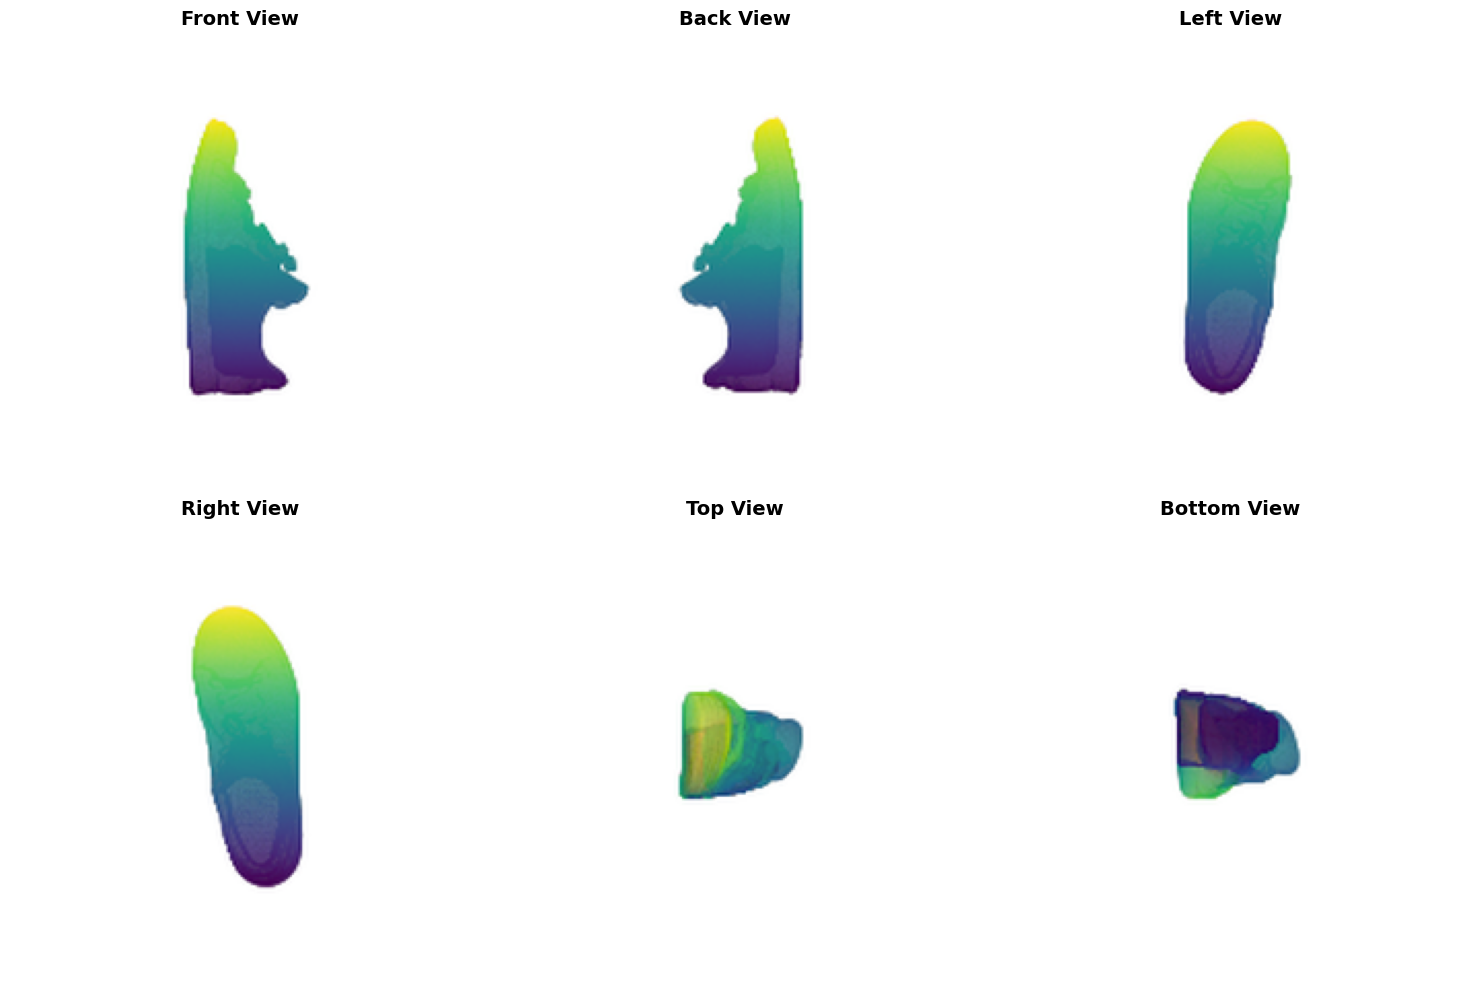

In [16]:

# Render all views
rendered_views = {}
print("\nRendering views...")
for view_name, (azim, elev) in views.items():
    print(f"  Rendering {view_name} view...")
    img = render_view(mesh, azim, elev)
    rendered_views[view_name] = img

# Visualize the 6 views
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (view_name, img) in enumerate(rendered_views.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(f'{view_name.capitalize()} View', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('multi_view_renders.png', dpi=150, bbox_inches='tight')
plt.show()


In [17]:

# ============================================
# PREPARE X (INPUT): Multi-view images
# ============================================

# Stack all views into a single array
X = np.stack([rendered_views[view] for view in ['front', 'back', 'left', 'right', 'top', 'bottom']])
print(f"\nX shape (multi-view images): {X.shape}")  # (6, 224, 224, 3)

# Alternative: Concatenate views as channels or flatten
X_flattened = X.reshape(6, -1)  # (6, 224*224*3)
print(f"X flattened shape: {X_flattened.shape}")

# ============================================
# PREPARE Y (OUTPUT): 3D representation
# ============================================

# Option 1: Voxel Grid (3D occupancy grid)
def mesh_to_voxels(mesh, resolution=32):
    """Convert mesh to voxel grid"""
    voxels = mesh.voxelized(pitch=2.0/resolution)
    grid = voxels.matrix
    return grid

Y_voxels = mesh_to_voxels(mesh, resolution=32)
print(f"\nY shape (voxel grid): {Y_voxels.shape}")  # (32, 32, 32)

# Option 2: Point Cloud
Y_points = mesh.sample(4096)  # Sample 4096 points from surface
print(f"Y shape (point cloud): {Y_points.shape}")  # (4096, 3)

# Option 3: Mesh vertices and faces (raw representation)
Y_vertices = mesh.vertices
Y_faces = mesh.faces
print(f"Y vertices shape: {Y_vertices.shape}")  # (N, 3)
print(f"Y faces shape: {Y_faces.shape}")  # (M, 3)



X shape (multi-view images): (6, 224, 224, 3)
X flattened shape: (6, 150528)

Y shape (voxel grid): (12, 13, 30)
Y shape (point cloud): (4096, 3)
Y vertices shape: (106469, 3)
Y faces shape: (185146, 3)


# We have run the code till here one one sample data point

In [ ]:

# ============================================
# SAVE DATASET
# ============================================

# Save the processed data
output_dir = '/content/3d_dataset'
os.makedirs(output_dir, exist_ok=True)

# Save multi-view images
np.save(f'{output_dir}/X_multiview.npy', X)

# Save different Y representations
np.save(f'{output_dir}/Y_voxels.npy', Y_voxels)
np.save(f'{output_dir}/Y_points.npy', Y_points)
np.save(f'{output_dir}/Y_vertices.npy', Y_vertices)
np.save(f'{output_dir}/Y_faces.npy', Y_faces)

print(f"\n✓ Dataset saved to {output_dir}/")


In [ ]:

# ============================================
# VISUALIZE Y (3D OUTPUT)
# ============================================

# Visualize voxel grid
fig = plt.figure(figsize=(15, 5))

# Voxel visualization
ax1 = fig.add_subplot(131, projection='3d')
filled = np.where(Y_voxels)
ax1.scatter(filled[0], filled[1], filled[2], c='blue', marker='s', s=5, alpha=0.5)
ax1.set_title('Voxel Grid (32³)', fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Point cloud visualization
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(Y_points[:, 0], Y_points[:, 1], Y_points[:, 2], c='red', s=1, alpha=0.6)
ax2.set_title('Point Cloud (4096 points)', fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Original mesh visualization
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(Y_vertices[:, 0], Y_vertices[:, 1], Y_vertices[:, 2],
                  triangles=Y_faces, cmap='viridis', alpha=0.7)
ax3.set_title('Original Mesh', fontweight='bold')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
plt.savefig('3d_representations.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# SUMMARY
# ============================================

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"INPUT (X):")
print(f"  - Multi-view images: {X.shape}")
print(f"  - 6 views from: front, back, left, right, top, bottom")
print(f"  - Resolution: 224x224x3 (RGB)")
print(f"\nOUTPUT (Y) - Choose one based on your model:")
print(f"  1. Voxel Grid: {Y_voxels.shape}")
print(f"     → Good for: 3D CNNs, occupancy prediction")
print(f"  2. Point Cloud: {Y_points.shape}")
print(f"     → Good for: PointNet, point-based networks")
print(f"  3. Mesh (vertices + faces):")
print(f"     - Vertices: {Y_vertices.shape}")
print(f"     - Faces: {Y_faces.shape}")
print(f"     → Good for: Graph neural networks, mesh generation")
print("="*60)

# Example: How to load the data later
print("\nTo load the data later:")
print("""
X = np.load('/content/3d_dataset/X_multiview.npy')
Y_voxels = np.load('/content/3d_dataset/Y_voxels.npy')
Y_points = np.load('/content/3d_dataset/Y_points.npy')
""")